# This notebook performs a crucial validation of the featurized dataset
# created by src/data_processing/featurizer_diffusion.py.
# It ensures data integrity, correct shapes, and physical plausibility.

In [35]:

import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from glob import glob
from tqdm.notebook import tqdm

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config

In [ ]:
# --- 1. Configuration Loading ---
print("--- Loading Configuration ---")
config_path = os.path.join(PROJECT_ROOT, 'configs', 'main_config.yaml')
config = load_config(config_path)

FEATURIZED_DIR = config['data']['featurized_dir_onlyxy']
HISTORY_STEPS = int(config['trajectory']['history_sec'] / config['trajectory']['dt']) + 1 # 11
FUTURE_STEPS = int(config['trajectory']['future_sec'] / config['trajectory']['dt']) # 80
TRAJECTORY_DIM = config['model']['trajectory_dim'] # 3 (x, y, heading)

# Feature dimensions (must match feature_extractor.py and config)
NUM_AGENTS = config['features']['num_agents'] # 16
NUM_MAP_POLYLINES = config['features']['num_map_polylines'] # 64
MAP_POINTS_PER_POLYLINE = config['features']['map_points_per_polyline'] # 10
NUM_GOAL_POINTS = config['features']['num_goal_points'] # 5

print(f"Featurized data directory: {FEATURIZED_DIR}")
print(f"Expected future trajectory shape: ({FUTURE_STEPS}, {TRAJECTORY_DIM})")
print("--- Configuration Loaded ---")

--- Loading Configuration ---
Configuration loaded successfully.
Featurized data directory: /mnt/d/waymo_datasets/modern_virtuoso_data/featurized_v3_diffusion
Expected future trajectory shape: (80, 3)
--- Configuration Loaded ---


In [37]:
# --- 2. Data Loading & Selection ---
print("\n--- Listing Featurized Files ---")
# Get a list of all featurized .pt files (from both training and validation subdirs)
all_featurized_files = glob(os.path.join(FEATURIZED_DIR, '*', '*.pt'))

if not all_featurized_files:
    raise FileNotFoundError(f"No .pt files found in '{FEATURIZED_DIR}'. "
                            "Please run featurizer_diffusion.py first.")

print(f"Found {len(all_featurized_files)} featurized scenarios.")

# Select a few random files for detailed inspection and visualization
num_samples_to_inspect = min(10, len(all_featurized_files))
selected_files = random.sample(all_featurized_files, num_samples_to_inspect)

print(f"Selected {num_samples_to_inspect} random files for inspection.")


--- Listing Featurized Files ---
Found 975 featurized scenarios.
Selected 10 random files for inspection.


In [38]:
# --- 3. Automated Validation Checks ---
print("\n--- Running Automated Validation Checks ---")
validation_successful = True

# Define expected state_dict structure for validation
# This needs to be precisely matched with feature_extractor.py and the state_dict definition.
expected_state_shapes_dtypes = {
    'ego_history': ((HISTORY_STEPS, 3), np.float32), # Check for (11, 3) history
    'ego_history_mask': ((HISTORY_STEPS,), np.bool_),
    'agents': ((NUM_AGENTS, 11), np.float32), # <-- Change 10 to 11
    'agents_mask': ((NUM_AGENTS,), np.bool_),
    'map': ((NUM_MAP_POLYLINES, MAP_POINTS_PER_POLYLINE, 2), np.float32), # Check for (64, 10, 2)
    'map_mask': ((NUM_MAP_POLYLINES,), np.bool_),
    'traffic_lights': ((2,), np.float32),
    'traffic_lights_mask': ((1,), np.bool_),
    'goal': ((NUM_GOAL_POINTS, 2), np.float32),
    'goal_mask': ((NUM_GOAL_POINTS,), np.bool_),
}

for i, file_path in enumerate(tqdm(selected_files, desc="Checking files")):
    try:
        sample = torch.load(file_path, map_location='cpu', weights_only=False)
        scenario_id = os.path.basename(file_path).replace('.pt', '')

        # Check top-level keys
        assert 'state' in sample, f"Missing 'state' key in {scenario_id}"
        assert 'target_trajectory' in sample, f"Missing 'target_trajectory' key in {scenario_id}"

        # Check target_trajectory
        target_trajectory = sample['target_trajectory']
        assert isinstance(target_trajectory, np.ndarray), f"Target trajectory is not numpy array in {scenario_id}"
        assert target_trajectory.shape == (FUTURE_STEPS, TRAJECTORY_DIM), \
            f"Target trajectory shape mismatch in {scenario_id}: Expected ({FUTURE_STEPS}, {TRAJECTORY_DIM}), Got {target_trajectory.shape}"
        assert np.isfinite(target_trajectory).all(), f"NaN/inf in target_trajectory in {scenario_id}"
        
        # Check state_dict
        state_dict = sample['state']
        assert isinstance(state_dict, dict), f"State is not a dictionary in {scenario_id}"

        for key, (expected_shape, expected_dtype) in expected_state_shapes_dtypes.items():
            assert key in state_dict, f"Missing state key '{key}' in {scenario_id}"
            tensor = state_dict[key]
            
            assert isinstance(tensor, np.ndarray), f"State tensor '{key}' is not numpy array in {scenario_id}"
            assert tensor.shape == expected_shape, \
                f"Shape mismatch for '{key}' in {scenario_id}: Expected {expected_shape}, Got {tensor.shape}"
            assert tensor.dtype == expected_dtype, \
                f"Dtype mismatch for '{key}' in {scenario_id}: Expected {expected_dtype}, Got {tensor.dtype}"
            assert np.isfinite(tensor).all(), f"NaN/inf in state tensor '{key}' in {scenario_id}"

    except AssertionError as e:
        print(f"❌ Validation FAILED for {file_path}: {e}")
        validation_successful = False
        break
    except Exception as e:
        print(f"❌ An unexpected error occurred while processing {file_path}: {e}")
        validation_successful = False
        break

if validation_successful:
    print("✅ Automated validation checks PASSED for all selected files!")
else:
    print("❌ Automated validation checks FAILED. Please review the errors above.")
    sys.exit(1) # Exit if validation failed



--- Running Automated Validation Checks ---


Checking files:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Automated validation checks PASSED for all selected files!



--- Running Qualitative Validation (Visualizations) ---
Traffic light state for 12eb68bca5b09228: Green/None at distance 0.00m
Traffic light state for 107c212cfa9ab384: Red at distance 16.05m
Traffic light state for 12d9cd660038da: Green/None at distance 0.00m
Traffic light state for 12820c2119eb16f: Green/None at distance 0.00m
Traffic light state for 109d6b5152f387f: Green/None at distance 0.00m
Traffic light state for 129da07a515367c9: Green/None at distance 0.00m
Traffic light state for 10458245acc916a: Red at distance 90.62m
Traffic light state for 10f764d9b4b4ad02: Green/None at distance 0.00m
Traffic light state for 116e9cc13060b0e9: Green/None at distance 0.00m
Traffic light state for 10f738e70b450c7f: Green/None at distance 0.00m


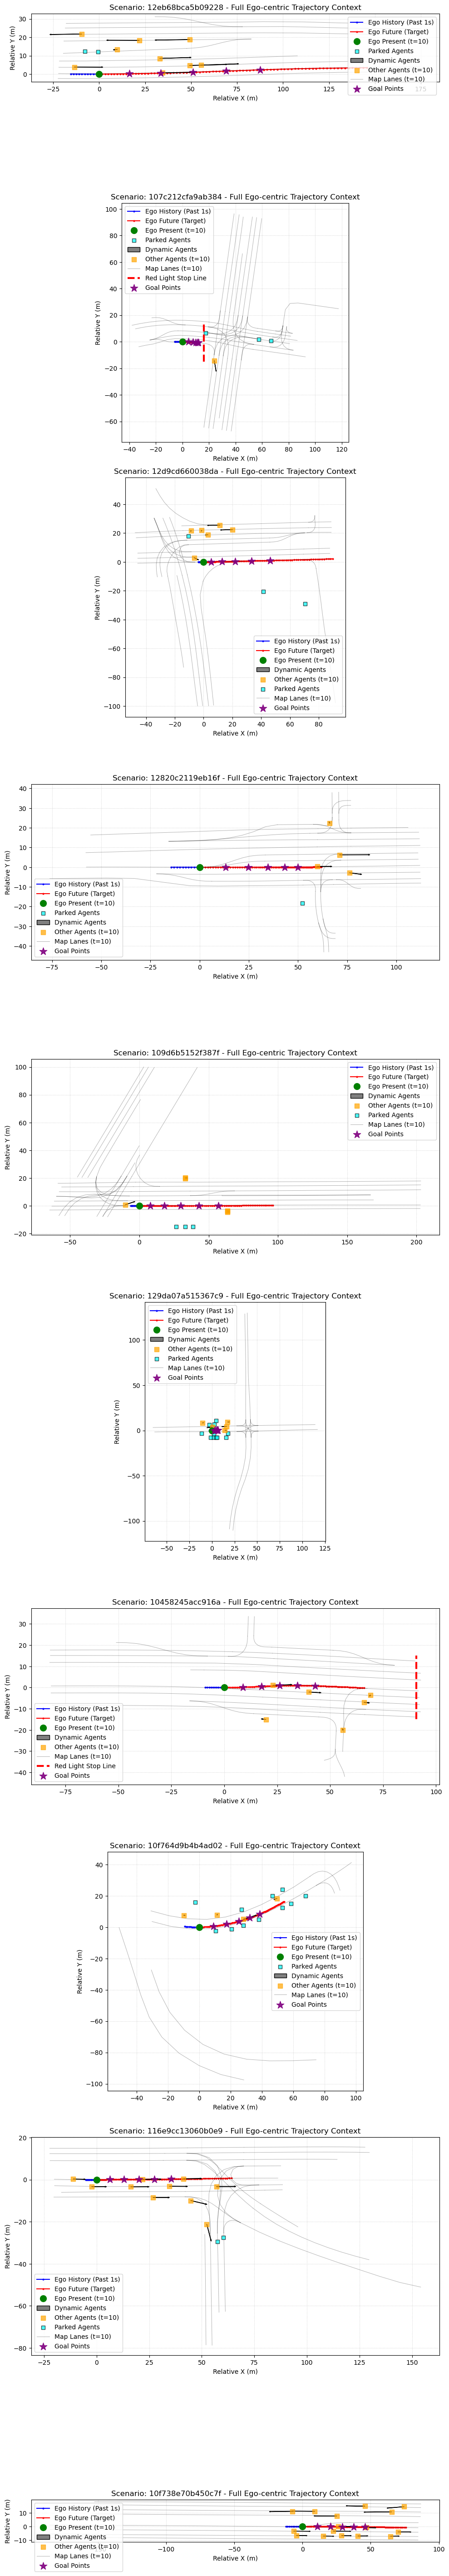


--- Qualitative validation complete. Please inspect plots for physical plausibility. ---


In [39]:
# --- 4. Qualitative Validation (Visualizations) ---
print("\n--- Running Qualitative Validation (Visualizations) ---")

fig, axes = plt.subplots(num_samples_to_inspect, 1, figsize=(10, 6 * num_samples_to_inspect)) # Increased height for clarity
if num_samples_to_inspect == 1:
    axes = [axes] # Ensure axes is iterable even for a single plot

for i, file_path in enumerate(selected_files):
    sample = torch.load(file_path, map_location='cpu', weights_only=False) # Removed weights_only for compatibility
    scenario_id = os.path.basename(file_path).replace('.pt', '')
    
    ax = axes[i]
    target_trajectory = sample['target_trajectory']
    state_dict = sample['state']

    # --- NEW: Plot Ego History ---
    ego_history = state_dict['ego_history']
    ego_history_mask = state_dict['ego_history_mask']
    valid_history = ego_history[ego_history_mask]
    # The last point of the history is the present, so we plot up to the second-to-last point
    ax.plot(valid_history[:, 0], valid_history[:, 1], 'b.-', markersize=4, linewidth=1.5, label='Ego History (Past 1s)')

    # Plot ego's future trajectory (x,y)
    ax.plot(target_trajectory[:, 0], target_trajectory[:, 1], 'r.-', markersize=4, linewidth=1.5, label='Ego Future (Target)')
    
    # Plot current ego position (origin of ego-centric frame)
    # This point connects the history and the future
    ax.plot(0, 0, 'go', markersize=10, label='Ego Present (t=10)', zorder=10)

    # --- UPDATED: Plot agents with velocity arrows ---
    agents = state_dict['agents']
    agents_mask = state_dict['agents_mask']
    valid_agents = agents[agents_mask]
    
    # Use a flag to ensure the legend is only added once
    dynamic_plotted = False
    parked_plotted = False
    for agent_state in valid_agents:
        x, y, vx, vy = agent_state[0], agent_state[1], agent_state[2], agent_state[3]
        is_parked = agent_state[10] > 0.5

        if is_parked:
            if not parked_plotted:
                ax.scatter(x, y, c='cyan', marker='s', s=40, label='Parked Agents', zorder=4, alpha=0.7, edgecolors='black')
                parked_plotted = True
            else:
                ax.scatter(x, y, c='cyan', marker='s', s=40, zorder=4, alpha=0.7, edgecolors='black')
        else: # It's a dynamic agent
            if not dynamic_plotted:
                ax.arrow(x, y, vx, vy, head_width=0.5, width=0.1, fc='gray', ec='black', 
                         label='Dynamic Agents', zorder=5)
                ax.scatter(x, y, c='orange', marker='s', s=50, label='Other Agents (t=10)', alpha=0.7, zorder=6)
                dynamic_plotted = True
            else:
                ax.arrow(x, y, vx, vy, head_width=0.5, width=0.1, fc='gray', ec='black', zorder=5)
                ax.scatter(x, y, c='orange', marker='s', s=50, alpha=0.7, zorder=6)

    # Plot map polylines
    map_geometry = state_dict['map']
    map_mask = state_dict['map_mask']
    # Use a flag to ensure the label is only added once for clarity
    map_plotted_label = False
    for polyline_points in map_geometry[map_mask]:
        if not map_plotted_label:
            ax.plot(polyline_points[:, 0], polyline_points[:, 1], 'k-', linewidth=0.7, alpha=0.3, label='Map Lanes (t=10)')
            map_plotted_label = True
        else:
            ax.plot(polyline_points[:, 0], polyline_points[:, 1], 'k-', linewidth=0.7, alpha=0.3)
        
    traffic_light_state = state_dict['traffic_lights']
    is_red_ahead = traffic_light_state[0] > 0.5 # Check the 'is_red_light_ahead' flag
    print(f"Traffic light state for {scenario_id}: {'Red' if is_red_ahead else 'Green/None'} at distance {traffic_light_state[1]:.2f}m")
    if traffic_light_state[1] > 0.0: # Valid distance
        if is_red_ahead:
            stop_line_dist = traffic_light_state[1] # Get the longitudinal distance
            # Draw a thick red dashed line at the stop distance, spanning across lanes
            ax.plot([stop_line_dist, stop_line_dist], [-15, 15], 'r--', linewidth=3, label='Red Light Stop Line', zorder=4)
        else:
            # Optionally, indicate green light with a green dashed line
            stop_line_dist = traffic_light_state[1]
            ax.plot([stop_line_dist, stop_line_dist], [-15, 15], 'g--', linewidth=3, label='Green Light Line', zorder=4)

    # Plot goal points
    goal_points = state_dict['goal']
    goal_mask = state_dict['goal_mask']
    valid_goal_points = goal_points[goal_mask]
    ax.scatter(valid_goal_points[:, 0], valid_goal_points[:, 1], c='purple', marker='*', s=150, label='Goal Points', alpha=0.9, zorder=11)

    ax.set_title(f'Scenario: {scenario_id} - Full Ego-centric Trajectory Context')
    ax.set_xlabel('Relative X (m)')
    ax.set_ylabel('Relative Y (m)')
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc='best')
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # Make zoom on the plot for better visibility
    # ax.set_xlim(-30, 30)
    # ax.set_ylim(-30, 30)

plt.tight_layout()
plt.show()

print("\n--- Qualitative validation complete. Please inspect plots for physical plausibility. ---")